# Analysis of sales data from top 10,000 Etsy shops.

In [1]:
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from IPython.display import display, HTML

# Stats
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import kendalltau, ttest_ind, spearmanr

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

# ML
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Load dataframe
df = pd.read_csv("data/etsy_04-03_Top10000_Shops.csv", encoding='latin1') # loading on Mac
# df = pd.read_csv("data/etsy_04-03_Top10000_Shops.csv", encoding = 'Windows-1252') # loading on Windows

In [3]:
# Convert 'shop_create_date' column to datetime
df['shop_create_date'] = df['shop_create_date'].apply(lambda x: datetime.fromtimestamp(x))

# Calculate the shop age in days
df['shop_age'] = (datetime.now().date() - df['shop_create_date'].dt.date).dt.days

We computed the 'Shop Age' variable by subtracting the shop creation date from the current date and time. The newly derived `shop_age` variable will serve as a key component in our analysis, allowing us to explore the relationship between a shop's age and its corresponding sold count. By considering this composite variable, we aim to gain valuable insights into how the age of a shop impacts its sales performance.

# Exploratory Data Analysis

#### View first 5 rows

In [4]:
df.head(5) # quickly check how rows look like

,shop_id,shop_name,url,shop_create_date,shop_update_date,digital_listing_count,digital_delivery_listing_count,is_open,seller_name,sold_count,...,accepts_direct_checkout,accepts_paypal,ships_to_country_ids,display_name,is_eligible_free_shipping,has_min_free_shipping,has_free_shipping,ships_to_regions,RunDate,shop_age
0,9811209,PlannerKate1,https://www.etsy.com/shop/PlannerKate1,2014-07-29 19:38:10,1649003016,0,0,True,Kate Antesberger,1839198,...,True,False,"[209, 0, 150, 79, 175]",Kate,False,False,False,['ANY'],4/3/2022 12:05,3260
1,10204022,CaitlynMinimalist,https://www.etsy.com/shop/CaitlynMinimalist,2014-11-02 00:08:19,1649004834,0,0,True,Kate Kim,1565708,...,True,False,"[79, 167, 290, 284, 209, 61, 58, 74, 105, 55, ...",Kate,True,False,True,['ANY'],4/3/2022 12:05,3164
2,9901413,Beadboat1,https://www.etsy.com/shop/Beadboat1,2014-08-19 21:31:10,1649003805,0,0,True,Katy,1461640,...,True,False,"[70, 118, 146, 90, 151, 79, 207, 91, 71, 215, ...",Katy,True,True,True,"['AL', 'AM', 'AU', 'AT', 'BE', 'BG', 'BY', 'BR...",4/3/2022 12:05,3239
3,8617622,ModParty,https://www.etsy.com/shop/ModParty,2013-09-26 17:35:41,1649001097,1,0,True,ModParty,1285848,...,True,False,"[175, 61, 80, 220, 219, 204, 56, 103, 79, 128,...",ModParty,False,False,False,['US'],4/3/2022 12:05,3566
4,5413707,yakutum,https://www.etsy.com/shop/yakutum,2010-09-03 23:07:37,1648988418,0,0,True,yakutum,969314,...,True,True,"[209, 167, 127, 0, 203, 61, 131]",yakutum,False,False,False,['ANY'],4/3/2022 12:05,4685


#### Open dataframe in a new window
The .head() method is not displaying all columns due to the large dataframe width. To facilitate a comprehensive view of the dataframe, we converted it into an HTML file and provided a link to open it in a new tab. This allows for a detailed examination of the dataframe in a larger, dedicated window.

In [5]:
# Use to_html() to convert the DataFrame into an HTML table, and write it to an HTML file
with open('shops.html', 'w') as f:
    f.write(df.to_html())

# Then create a link to the new HTML file
display(HTML('<a href="shops.html" target="_blank">Open DataFrame in New Tab</a>'))

#### View all available colums and their types

In [6]:
df_dtypes = df.dtypes
print(df_dtypes)

shop_id                                    int64
shop_name                                 object
url                                       object
shop_create_date                  datetime64[ns]
shop_update_date                           int64
digital_listing_count                      int64
digital_delivery_listing_count             int64
is_open                                     bool
seller_name                               object
sold_count                                 int64
additional_customization                    bool
active_listing_count                       int64
status                                    object
location                                  object
city                                      object
region                                    object
name                                      object
headline                                  object
favorites_count                            int64
average_rating                           float64
total_rating_count  

The Etsy dataset contains various variables that provide insights into the characteristics and attributes of the shops within the dataset. <br>Here is a brief description of some of the most relevant variables we will be using in our study:

- **Additional Customization** (Boolean): This variable indicates whether or not a shop offers additional customization options to its customers. Shops with more customization might attract more customers due to the uniqueness of their products.
- **Accepts Direct Checkout** (Boolean): This variable shows if a shop accepts direct checkout payments. Accepting direct checkout could influence sales as it provides a more streamlined payment process.
- **Accepts PayPal** (Boolean): This variable indicates whether a shop accepts PayPal as a payment option. Offering popular payment options such as PayPal can impact sales by increasing the accessibility for customers to make purchases.
- **Has Free Shipping** (Boolean): This variable specifies if a shop offers free shipping. Offering free shipping might attract more customers due to the perceived value.
- **Is Eligible For Free Shipping** (Object): This variable indicates whether a shop is eligible to offer free shipping. Shops eligible for free shipping could have an advantage in attracting customers who prioritize free shipping in their purchase decision.
- **Has Min Free Shipping** (Object): This variable shows if a shop offers free shipping after reaching a minimum order amount. This could incentivize customers to buy more in order to qualify for free shipping.
- **Active Listing Count** (Integer): This variable represents the number of active listings a shop has. Shops with more active listings might have more visibility and therefore, higher sales.
- **Digital Listing Count** (Integer): This variable shows the number of digital listings a shop has. Shops with a high number of digital listings could attract a different demographic of customers interested in digital products.
- **Shop Age** (in days, Integer): This variable measures the age of the shop in days. Older shops might have established a larger customer base, therefore having higher sales.
- **Favorites Count** (Integer): This variable indicates the number of favorites a shop has. Shops with more favorites might be more popular, leading to higher sales.
- **Average Rating** (Float): This variable shows the average rating of a shop. Higher ratings might attract more customers due to the perceived quality of products and services.
- **Total Rating Count** (Integer): This variable indicates the total number of ratings a shop has received. A high total rating count might be an indicator of customer engagement and could relate to higher sales.
- **Average Rating Count** (Float): This variable represents the average number of ratings a shop receives. Higher average rating count could indicate customer satisfaction and therefore, higher sales.
- **Sold Count** (Integer): This is our target variable. It represents the total number of items a shop has sold. Our goal is to predict this variable based on the features described above. Higher sold count indicates better performance of the shop.

#### Key metrics and descriptive statistics 

In [7]:
average_sold_count = df['sold_count'].mean()
print(f"Average sold count: {round(average_sold_count)}")

average_active_listings = df['active_listing_count'].mean()
max_active_listings = df['active_listing_count'].max()
min_active_listings = df['active_listing_count'].min()

print("Average Active Listings: ", average_active_listings)
print("Maximum Active Listings: ", max_active_listings)
print("Minimum Active Listings: ", min_active_listings)

average_rating = df['average_rating'].mean()
total_reviews = df['total_rating_count'].sum()

print("Average Rating: ", average_rating)
print("Total Reviews: ", total_reviews)

top_countries = df['country_code'].value_counts().head(5)
print("Top Countries with Highest Number of Shops: ")
print(top_countries)

df.describe()

Average sold count: 53484
Average Active Listings:  851.3128
Maximum Active Listings:  83954
Minimum Active Listings:  0
Average Rating:  4.896958330831582
Total Reviews:  84714734
Top Countries with Highest Number of Shops: 
US    6299
GB     949
CA     375
CN     192
DE     140
Name: country_code, dtype: int64


,shop_id,shop_update_date,digital_listing_count,digital_delivery_listing_count,sold_count,active_listing_count,favorites_count,average_rating,total_rating_count,average_rating_count,geoname_id,primary_language_id,shop_age
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,9993.000000,10000.000000,9993.000000,1.000000e+04,10000.000000,10000.000000
mean,1.160696e+07,1.648934e+09,165.382200,0.502100,5.348419e+04,851.312800,7625.960200,4.896958,8471.473400,1964.225958,3.875878e+06,0.069600,3134.755800
std,5.558173e+06,1.054144e+06,624.904367,13.586576,6.216968e+04,1855.144018,9812.055333,0.107211,10895.584957,2955.169041,1.946584e+06,0.607612,1122.993405
min,5.037340e+06,1.579426e+09,0.000000,0.000000,2.272900e+04,0.000000,88.000000,1.000000,411.000000,1.000000,0.000000e+00,0.000000,598.000000
25%,6.815317e+06,1.648986e+09,0.000000,0.000000,2.806850e+04,167.000000,2388.000000,4.868700,3853.500000,609.000000,2.644210e+06,0.000000,2258.000000
50%,1.017316e+07,1.649000e+09,0.000000,0.000000,3.675000e+04,419.000000,4744.000000,4.924100,5871.000000,1234.000000,4.586268e+06,0.000000,3173.000000
75%,1.505625e+07,1.649014e+09,2.000000,0.000000,5.630550e+04,940.000000,9247.500000,4.958300,9281.000000,2350.000000,5.310193e+06,0.000000,4123.250000
max,3.280814e+07,1.649118e+09,22706.000000,741.000000,1.839198e+06,83954.000000,258218.000000,5.000000,267763.000000,113772.000000,1.182063e+07,19.000000,4685.000000


Quick Insights:
- **Most shops in our dataset do not focus on digital listings**, given that 50% of shops have zero digital listings, and 75% of shops have two or less. However, there are a few extreme outliers, with the maximum digital listing count being 22,706.
- The minimum sold count is 22,729, the median is 36,750, and the maximum is a whopping 1,839,198, suggesting a few very successful outliers. With a standard deviation larger than the mean, **the sold counts are quite dispersed**.
- **On average, a shop has about 851 active listings**, but this value varies widely as evidenced by a large standard deviation (about 1855). The maximum active listing count is 83,954, which is significantly higher than the 75th percentile value of 940, indicating the presence of outliers with very high active listing counts.
- **On average, a shop has about 7625 favorites**. However, the favorite counts also vary widely (standard deviation is around 9812), with the most favorited shop having received 258,218 favorites.
- **Shops in the dataset are generally well-rated, with a mean rating of approximately 4.90**. Ratings are not very dispersed, with a relatively small standard deviation of 0.11, suggesting most shops maintain a high quality of products or services. However, there are exceptions as the minimum rating is 1.
- On average, shops have around 8471 total ratings and around 1964 average ratings. However, with high standard deviations and maximum values (267763 and 113772 respectively), it's clear that some shops have received significantly more ratings than others, again indicating the presence of successful outliers.
- Geoname ID & Primary Language ID are likely identifiers related to the geographic location of the shop and the primary language used by the shop, respectively. A wide variety of values is present, indicating diverse locations and languages among the shops. The **primary language seems to be 0 for most shops (English)**.
- Shop Age: The shops in our dataset have been operational for an average of around 3135 days (or approximately 8.6 years), indicating that your dataset consists largely of established shops. However, there's considerable variation in shop ages, as **the youngest shop has been operational for only 598 days (~1.6 years), while the oldest shop has been running for 4685 days (~12.8 years)**. This wide range shows that the dataset includes a good mix of relatively new and seasoned Etsy shops.

#### Missing values

In [8]:
# Calculate the total number of missing values in each column
df_missing_count = df.isna().sum()
print(df_missing_count)

shop_id                              0
shop_name                            0
url                                  0
shop_create_date                     0
shop_update_date                     0
digital_listing_count                0
digital_delivery_listing_count       0
is_open                              0
seller_name                          0
sold_count                           0
additional_customization             0
active_listing_count                 0
status                               0
location                          1292
city                              7397
region                            7430
name                                 0
headline                           494
favorites_count                      0
average_rating                       7
total_rating_count                   0
average_rating_count                 7
geoname_id                           0
country_code                       973
currency_code                        0
has_currency_code        

####  Remove relevant rows with missing values
We observe that our dataset has missing values across various columns, including 'display_name', 'region', 'headline', and 'ships_to_regions', among others. However, for the purpose of our analysis, not all of these missing values will impact our results. Thus, our approach will be to specifically target and eliminate missing values from those columns that are crucial for our analysis, and the presence of these missing values could skew our results.

As such, our next code snippet is focused on handling these missing values:

In [9]:
df = df.dropna(subset=['average_rating', 'average_rating_count'])

#### What is the span of the date from this dataset?

In [10]:
# Convert 'shop_create_date' column to datetime format
df['shop_create_date'] = pd.to_datetime(df['shop_create_date'])

# Find the minimum and maximum dates
min_date = df['shop_create_date'].min()
max_date = df['shop_create_date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2010-09-03 22:27:42
Maximum Date: 2021-11-11 14:58:45


Among the top-selling 10,000 shops in the dataset, we analyzed the 'shop_create_date' column to determine the range of shop creation dates. The results indicate that the oldest shop in the dataset was created on September 3rd, 2010, while the most recent shop was created on November 11th, 2021. This reveals that the span of shop ages within the dataset covers approximately 11 years.

#### Which country code is included most to ship to?

In [11]:
# Expand list-like column into multiple rows
expanded_df = df.explode('ships_to_country_ids')

# Count the frequency of each country ID
country_counts = Counter(expanded_df['ships_to_country_ids'])

# Get the country ID with the maximum count
most_common_country_id = country_counts.most_common(1)[0][0]

print(f"The country ID included most to ship to is: {most_common_country_id}")  

The country ID included most to ship to is: [209, 0]


Based on the provided code and analysis, the most common country ID for shipping in the dataset is "209," which corresponds to the country code of the United States. Additionally, the value "0" represents international shipping, indicating that sellers also ship to countries outside the United States. However, the frequency count suggests that the majority of sellers primarily ship to regions within the United States. Therefore, we can conclude that the dataset predominantly includes sellers who ship to locations within the United States, while also catering to international shipping for customers located in other countries.

#### Which country code can be best included to ship to?
To determine the optimal country code for shipping, considering "best" as the country with the highest sales volume (based on `sold_count`), we can approach the problem as follows: First, we identify the country code for each shop. Next, we aggregate the `sold_count` for each country to determine which country has the highest sales volume.

In [12]:
# Group by 'country_code' and sum 'sold_count'
country_sales = df.groupby('country_code')['sold_count'].sum()

# Get the country code with the maximum sum of sales
best_country_code = country_sales.idxmax()

print(f"The best country code to ship to (based on total number of sales) is: {best_country_code}")

The best country code to ship to (based on total number of sales) is: US


#### Bar plot of the Top 10 Sellers based on the Sold Count
By creating a bar plot, we can easily identify the top 10 sellers based on the sold count. This visualization will provide a clear overview of the highest-performing sellers and their associated countries.

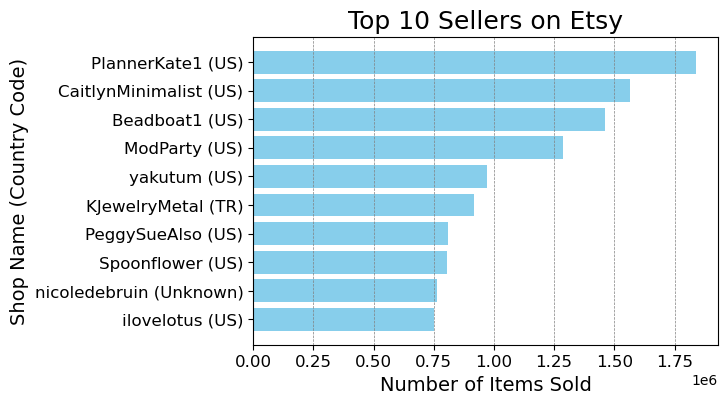

In [13]:
top_sellers = df.sort_values('sold_count', ascending=False).head(10)

# Fill missing values with a placeholder and convert the columns to string type
top_sellers['shop_name'] = top_sellers['shop_name'].fillna('Unknown').astype(str)
top_sellers['country_code'] = top_sellers['country_code'].fillna('Unknown').astype(str)

# Create the 'shop_country' column
top_sellers['shop_country'] = top_sellers['shop_name'] + ' (' + top_sellers['country_code'] + ')'

# Plot
plt.figure(figsize=(6, 4))
plt.barh(top_sellers['shop_country'], top_sellers['sold_count'], color='skyblue')
plt.title('Top 10 Sellers on Etsy', fontsize=18)
plt.xlabel('Number of Items Sold', fontsize=14)
plt.ylabel('Shop Name (Country Code)', fontsize=14)
plt.gca().invert_yaxis()  # Reverse the order of the sellers
plt.xticks(fontsize=12)   
plt.yticks(fontsize=12)  
plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.5)  
plt.show()

#### Distribution of the number of shops by country for the top 20 countries with most shops
The plot provides an overview of the distribution of shops among different countries, highlighting the top 20 countries with the highest shop counts. This visualization aids in understanding the relative prominence of countries in terms of the number of shops, allowing for easy comparison and identification of countries with a significant presence in the dataset.

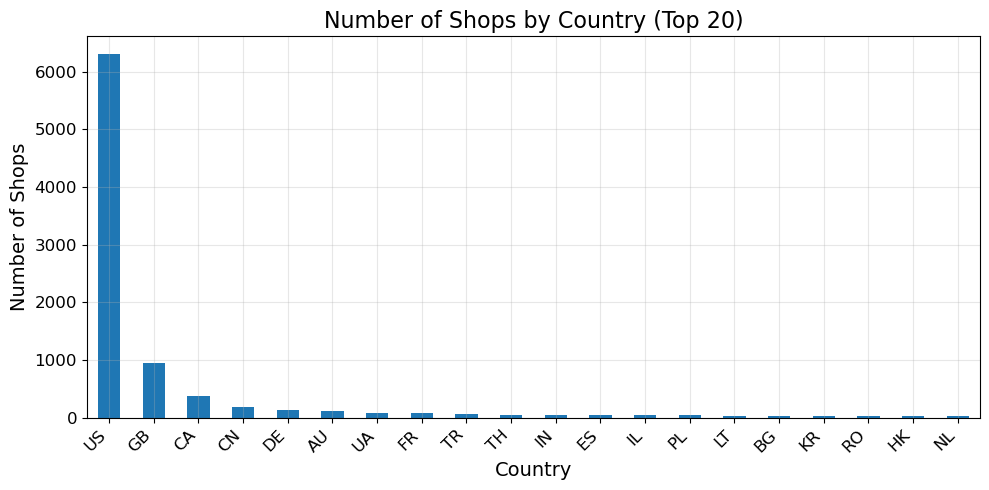

In [14]:
plt.figure(figsize=(10, 5)) 

# Filter the top 20 countries
top_countries = df['country_code'].value_counts().head(20)

# Plot the filtered data
top_countries.plot(kind='bar')

# Add gridlines
plt.grid(alpha=0.3)  

# Rotate labels for better visibility 
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.yticks(fontsize=12)   

plt.title('Number of Shops by Country (Top 20)', fontsize=16)  
plt.xlabel('Country', fontsize=14)  
plt.ylabel('Number of Shops', fontsize=14)   

plt.tight_layout()  
plt.show()

From the graph, we can observe that the United States (US), United Kingdom (GB), and Canada (CA) are among the top countries with the highest number of Etsy shops. These countries have a substantial presence in the Etsy marketplace, with a greater concentration of shops compared to other countries. They exhibit a strong entrepreneurial presence on the Etsy platform, indicating their popularity as hubs for creative artisans, crafters, and sellers. The concentration of shops in these countries suggests a vibrant creative community, potentially reflecting factors such as market demand, seller engagement, and a supportive environment for small businesses.

#### Barplot of Shop Creation Date and Sold Count: 
By examining the line plot, one can observe any patterns or trends in the mean sold count across different years of shop creation. This visualization helps to understand whether older shops tend to have higher or lower average sales counts, providing insights into the relationship between shop age and success in terms of items sold.

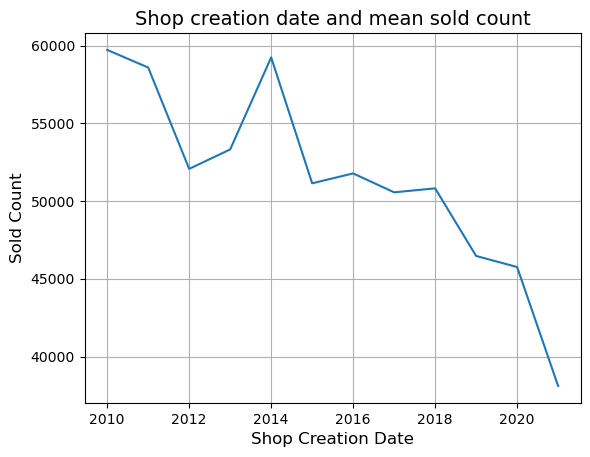

In [15]:
# Group by shop creation year and calculate the mean sold count
mean_sold_count = df.groupby(df['shop_create_date'].dt.year)['sold_count'].mean()

# Plot the mean sold count with grid
mean_sold_count.plot(grid=True)

# Set the labels and title with larger font size
plt.xlabel("Shop Creation Date", fontsize=12)
plt.ylabel("Sold Count", fontsize=12)
plt.title("Shop creation date and mean sold count", fontsize=14)
plt.show()

The line plot reveals interesting insights into the relationship between the age of the shop (i.e., its creation date) and the success of the shop in terms of items sold.

In the early years following 2012, we observe an initial increase in mean sold count. This could be due to the novelty of the platform, fewer competitors, or the pioneering shops capturing a significant portion of the early market.

Following this rise, we see a gradual decline in the mean sold count from around 2012 through 2018. This downward trend could be attributed to the influx of new sellers on the platform, leading to increased competition and dispersion of sales amongst a larger pool of sellers.

Overall, this graph indicates that while shop age can influence the average sales count, other factors and market dynamics also play a significant role. It underscores the complexity of predicting sales success on a multifaceted platform like Etsy.

#### Distribution of numerical features  
We created subplots to visualize the distribution of key numerical features that are of particular importance for our subsequent analysis. Each subplot represents one of the eight selected features: active listing count, digital listing count, favorites count, average rating, total rating count, average rating count, sold count, and shop age.

In each subplot, the data is log-transformed to better visualize the distribution. The x-axis represents the log-scaled values, while the y-axis indicates the frequency of occurrence. The histograms provide an overview of the distribution shape, highlighting any skewness or patterns in the data.

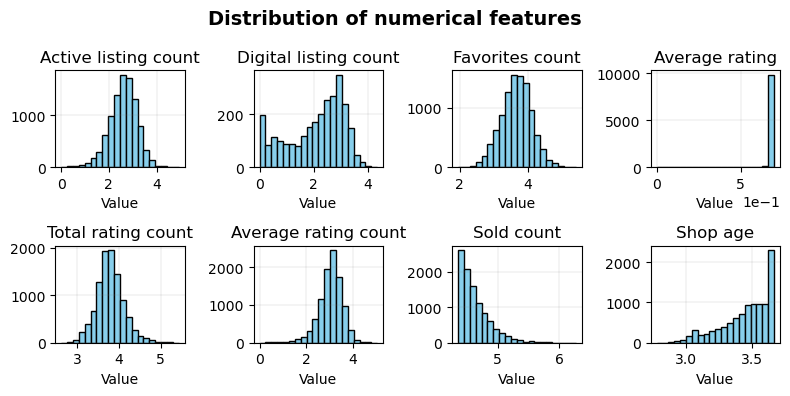

In [16]:
# Define the column names
cols = ['active_listing_count', 'digital_listing_count', 'favorites_count', 'average_rating', 'total_rating_count', 'average_rating_count', 'sold_count', 'shop_age']
titles = ['Active listing count', 'Digital listing count', 'Favorites count', 'Average rating', 'Total rating count', 'Average rating count', 'Sold count', 'Shop age']

fig = plt.figure(figsize=(8, 4))
fig.suptitle("Distribution of numerical features", fontsize=14, fontweight='bold')

for i, col in enumerate(cols):
    # Create a subplot in the i-th position of a 2x4 grid (plus one because subplot indices start at 1 not 0)
    ax = plt.subplot(2, 4, i+1)
    
    # Filter out any values less than or equal to zero, as they cannot be log-transformed
    data = df[col][df[col] > 0]
    
    # Log-transform the data
    log_data = np.log10(data)
    
    # Create a histogram in the subplot for the log-transformed data
    ax.hist(log_data, bins=20, color='skyblue', edgecolor='black')
    
    # Use scientific notation for x-axis ticks
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    # Add a title to the subplot
    ax.set_title(titles[i])
    
    # Add a subtle grey grid
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    # Add x-label explaining the log scale
    ax.set_xlabel('Value') #  (log10 scale)
    
plt.tight_layout()
plt.show()

We observe that certain features, such as 'digital listing count', 'average rating', 'shop age', and the dependent variable 'sold count', display non-normal distributions. These non-normal distributions are evident from the presence of skewness or asymmetry in the corresponding histograms. Additionally, clusters or peaks in the histograms indicate specific patterns within the data. These distinct patterns and characteristics emphasize the need to carefully consider and account for the non-normality when conducting further analysis on these predictors and the dependent variable.

However, the plots alone do not provide a clear indication of whether variables such as `active_listing_count`, `favorites_count`, `total_rating_count`, and `average_rating_count` follow a normal distribution. To gain a more precise understanding, we will delve deeper by creating larger histograms accompanied by Q-Q plots. 

#### Check if data is normally distributed
The histograms and Q-Q plots presented below offer a detailed examination of the distribution of `active_listing_count`, `average_rating`, `favorites_count`, and `sold_count` variables on a normal scale. The histograms display the shape of the distributions, while the Q-Q plots provide a visual comparison between the observed quantiles and the expected quantiles of a normal distribution. By analyzing the two subplots for each variable, it becomes evident that these features deviate from a normal distribution. 

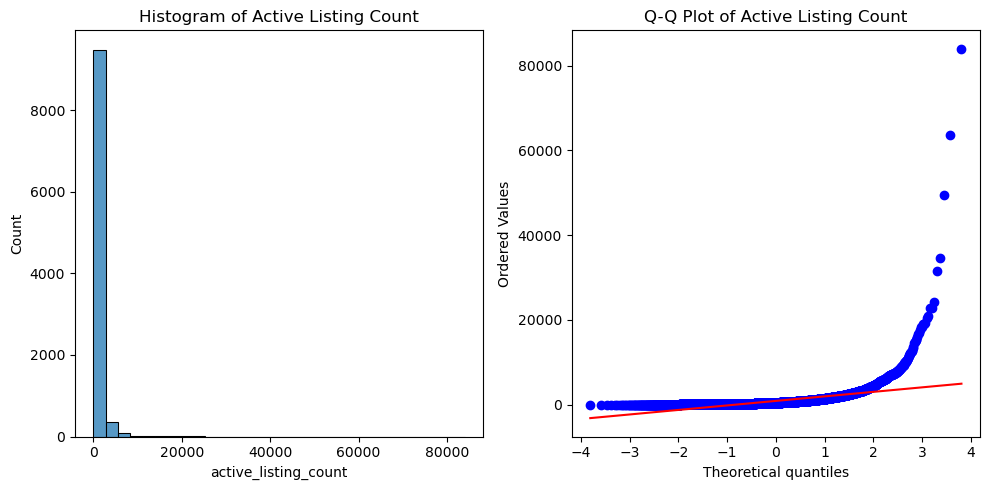

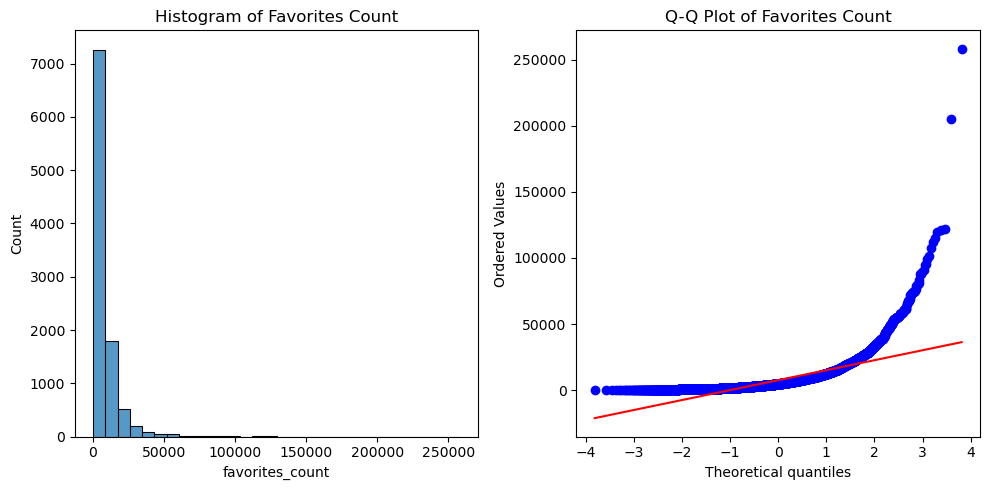

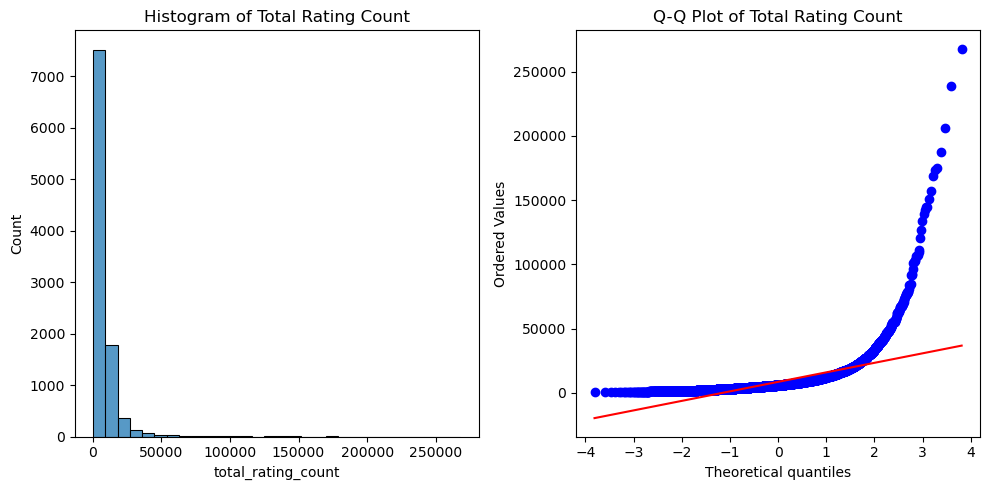

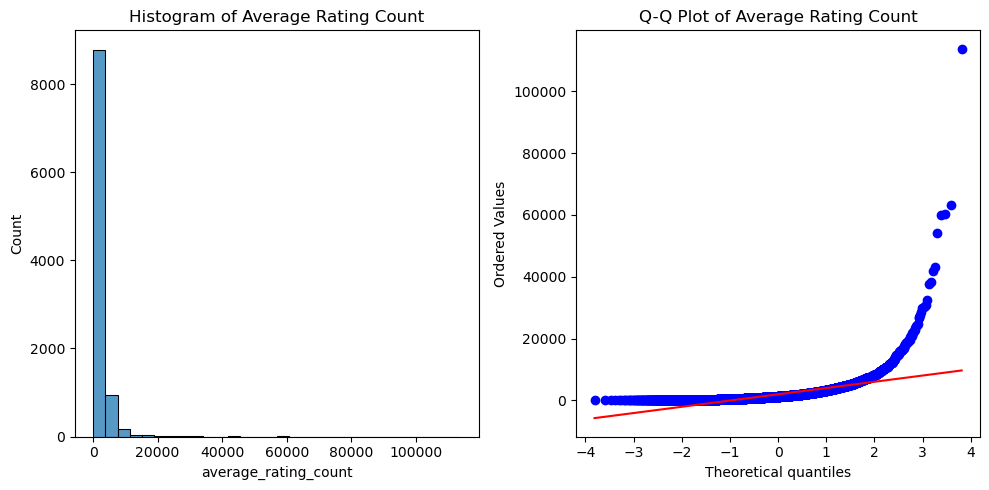

In [17]:
variables = ['active_listing_count', 'favorites_count', 'total_rating_count', 'average_rating_count']

for variable in variables:
    # Create a new figure with a size of 10x5
    plt.figure(figsize=(10, 5))   
    
    # Plot the histogram (left)
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30, kde=False)
    plt.title('Histogram of ' + variable.replace('_', ' ').title())
    
    # Plot the Q-Q plot (right)
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], plot=plt)
    plt.title('Q-Q Plot of ' + variable.replace('_', ' ').title())
    

    plt.tight_layout()   
    plt.show()


#### Check the normality of numerical variables 
The purpose of the following code is to assess the normality of relevant numerical variables. Building upon the insights gained from the previous section's subplots, which highlighted potential deviations from normal distribution, a normality test is conducted. This test aims to confirm whether these numerical variables adhere to a normal distribution. By performing this analysis, we gain a deeper understanding of the distributional characteristics of the variables, allowing us to make informed decisions regarding the choice of appropriate statistical techniques and assumptions for subsequent analysis.

In [18]:
# List of numerical columns
num_cols = ['active_listing_count', 'digital_listing_count', 'favorites_count', 'average_rating', 'total_rating_count', 'average_rating_count', 'sold_count', 'shop_age']

# Normality test
for col in num_cols:
    print(f'{col}:\n')
    # Drop NaN values
    column_data = df[col].dropna()
    # Exclude infinite values
    column_data = column_data[np.isfinite(column_data)]
    
    k2, p = stats.normaltest(column_data)
    print(f"Normality test statistic: {k2}")
    print(f"Normality test p-value: {p}")
    if p < 0.05:
        print(f"{col} does NOT follow a normal distribution\n")
    else:
        print(f"{col} follows a normal distribution <-------------\n")

active_listing_count:

Normality test statistic: 21194.352106298353
Normality test p-value: 0.0
active_listing_count does NOT follow a normal distribution

digital_listing_count:

Normality test statistic: 16534.67790592519
Normality test p-value: 0.0
digital_listing_count does NOT follow a normal distribution

favorites_count:

Normality test statistic: 11753.13940563881
Normality test p-value: 0.0
favorites_count does NOT follow a normal distribution

average_rating:

Normality test statistic: 14241.253286444913
Normality test p-value: 0.0
average_rating does NOT follow a normal distribution

total_rating_count:

Normality test statistic: 14148.602030285323
Normality test p-value: 0.0
total_rating_count does NOT follow a normal distribution

average_rating_count:

Normality test statistic: 17067.301681805955
Normality test p-value: 0.0
average_rating_count does NOT follow a normal distribution

sold_count:

Normality test statistic: 15696.18013626803
Normality test p-value: 0.0
sold_

The normality test, conducted using the `normaltest` function from the `scipy.stats` package, confirms the observations made from the previous histograms. The results indicate that the numerical features, including `active_listing_count`, `digital_listing_count`, `favorites_count`, `average_rating`, `total_rating_count`, `average_rating_count`, `sold_count`, `shop_age`, do not follow a normal distribution. This departure from normality implies that we need to consider alternative statistical approaches that do not assume normality when analyzing these variables in subsequent sections of our study.

Having gained a deeper understanding of the distributional characteristics of the numerical features, we are now equipped to proceed with addressing the research questions outlined in our study. The knowledge obtained from the exploratory data analysis, along with the non-normality of these variables, will guide us in selecting appropriate statistical methods and techniques to effectively analyze and interpret the data.

# RQ1: How does the **Average Rating** impact the **Sold Count** of a shop?

#### Using Linear Regression
Note: `average_rating` and `sold_count` are not normally distributed. Linear regression assumes that the variables are normally distributed. In cases where the data is not normally distributed, a non-parametric approach like Spearman's rank correlation or Kendall's tau could be used instead. However, in many real-world scenarios, we still use linear regression even if the data is not strictly normally distributed. In such cases, the coefficients should be interpreted with caution and the model's predictions should be evaluated thoroughly.

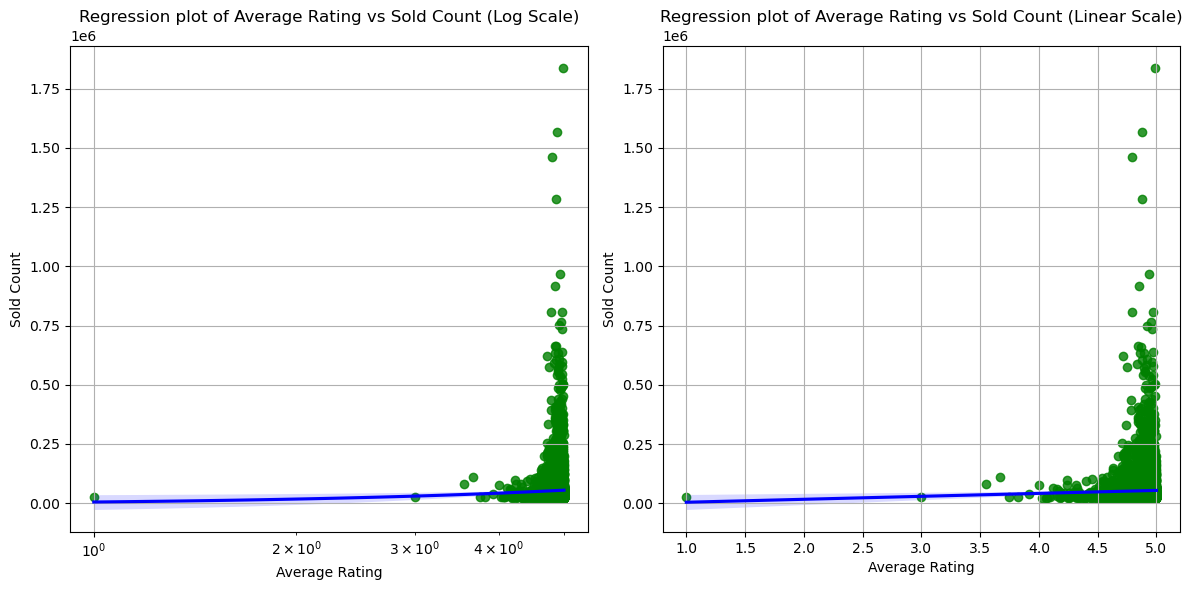

In [19]:
# First, we will calculate the correlation coefficient between 'average_rating' and 'sold_count'
correlation, p_value = stats.pearsonr(df['average_rating'], df['sold_count'])

# Prepare the data
X = df[['average_rating']]
y = df['sold_count']

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#print(f"Mean Squared Error: {mse}")
#print(f"R-squared: {r2}")

# Now, we will use a simple linear regression model to further investigate this relationship
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Regression plot with log scale
sns.regplot(x='average_rating', y='sold_count', data=df, scatter_kws={'color': 'green'}, line_kws={'color': 'blue', 'label': f"y={model.coef_[0]:.2f}x+{model.intercept_:.2f}, $R^2$={r2:.2f}"}, ax=ax1)
ax1.set_title('Regression plot of Average Rating vs Sold Count (Log Scale)')
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Sold Count')
ax1.set_xscale('log')
ax1.grid(True)
#ax1.legend()

# Subplot 2: Regression plot without log scale
sns.regplot(x='average_rating', y='sold_count', data=df, scatter_kws={'color': 'green'}, line_kws={'color': 'blue', 'label': f"y={model.coef_[0]:.2f}x+{model.intercept_:.2f}, $R^2$={r2:.2f}"}, ax=ax2)
ax2.set_title('Regression plot of Average Rating vs Sold Count (Linear Scale)')
ax2.set_xlabel('Average Rating')
ax2.set_ylabel('Sold Count')
ax2.grid(True)
#ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

#### Histogram of Average Ratings
A histogram can provide a good understanding of how average ratings and sold count are distributed across all shops. As one can see from the plotted graphs, these two columns are **Not** normally distributed. Therefore, we will be using Spearman's Correlation coefficient to measure for correlation between average rating and sold count.

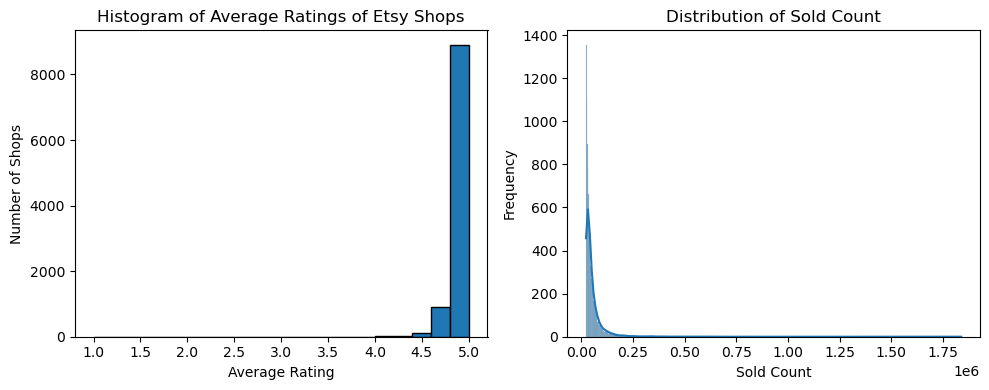

In [20]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Histogram of Average Ratings
ax1.hist(df['average_rating'], bins=20, edgecolor='black')
ax1.set_title('Histogram of Average Ratings of Etsy Shops')
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Number of Shops')

# Subplot 2: Distribution of Sold Count in normal scale
sns.histplot(df['sold_count'], kde=True, ax=ax2)
ax2.set_title('Distribution of Sold Count')
ax2.set_xlabel('Sold Count')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Spearman's correlation coefficient

In [21]:
# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(X, y)

print(f"Spearman's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman's correlation coefficient: 0.004715641617371589
P-value: 0.6373960017334752


Correlation between Average Rating and Sold Count is not statistically significant.

# RQ2: Does the **Favorites Count** of a shop have an impact on the **Sold Count**?

### Scatter plot of sold count vs. favorites count for shops
This can help us see if there's a correlation between the number of items a shop has sold and the number of favorites it has received. If there's a strong positive correlation, it could suggest that more popular shops (those with more favorites) also tend to sell more items.

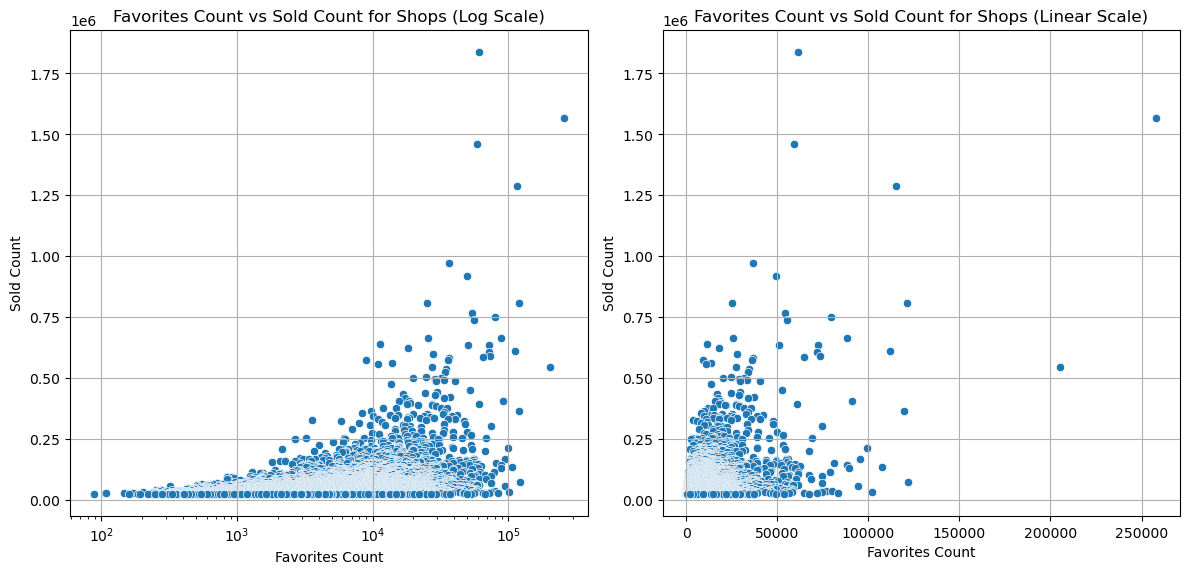

In [22]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Scatter plot with log scale
sns.scatterplot(x='favorites_count', y='sold_count', data=df, ax=ax1)
ax1.set_title('Favorites Count vs Sold Count for Shops (Log Scale)')
ax1.set_xlabel('Favorites Count')
ax1.set_ylabel('Sold Count')
ax1.set_xscale('log')
ax1.grid(True)

# Subplot 2: Scatter plot without log scale
sns.scatterplot(x='favorites_count', y='sold_count', data=df, ax=ax2)
ax2.set_title('Favorites Count vs Sold Count for Shops (Linear Scale)')
ax2.set_xlabel('Favorites Count')
ax2.set_ylabel('Sold Count')
ax2.grid(True)

plt.tight_layout()
plt.show()

This scatterplot seems to exhibit a positive correlation between the two variables. In other words, as the Favourites Count of a shop increases, the Sold Count also appears to increase. This relationship is characterized by a general upward trend in the data points.

The plot shows a wide dispersion of data points, suggesting significant variability in the relationship. However, despite this dispersion, the positive trendline suggests that on average, shops with a higher Favourites Count tend to have a higher Sold Count.

It's also noteworthy that the use of a logarithmic scale has the effect of reducing the impact of extreme values or outliers, providing a clearer view of the overall trend. This indicates a multiplicative (or exponential) relationship between the two variables - an increase in Favourites Count by a certain factor corresponds to an increase in Sold Count by a certain factor, rather than a certain amount.

Finally, the scattering of data points also indicates that while there's a general correlation, the relationship isn't perfectly linear.

#### Histogram of Favourites Count
A histogram can provide a good understanding of how Favourites Count and Sold Count are distributed across all shops. As one can see from the plotted graphs, these two columns are **Not** normally distributed. Therefore, we will be using the Kendall rank correlation coefficient to measure for correlation between Favourites Count and Sold Count.

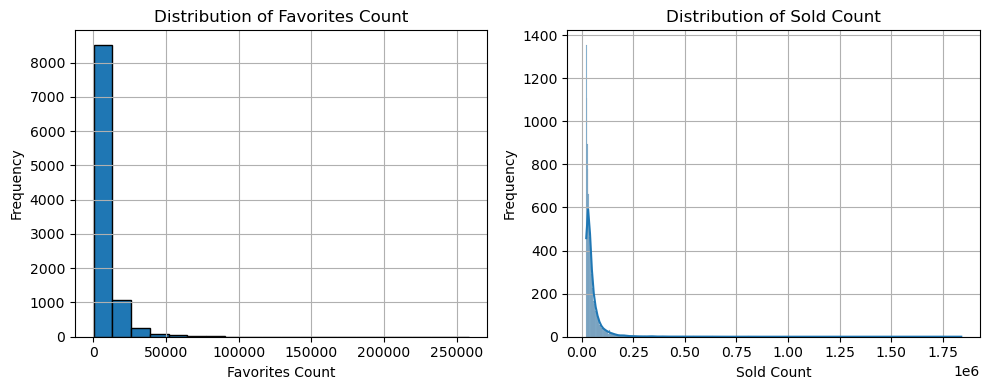

In [23]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Histogram of Favorites Count
ax1.hist(df['favorites_count'], bins=20, edgecolor='black')
ax1.set_title('Distribution of Favorites Count')
ax1.set_xlabel('Favorites Count')
ax1.set_ylabel('Frequency')
ax1.grid(True)

# Subplot 2: Distribution of Sold Count
sns.histplot(df['sold_count'], kde=True, ax=ax2)
ax2.set_title('Distribution of Sold Count')
ax2.set_xlabel('Sold Count')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

#### Kendall rank correlation coefficient

In [24]:
# If there are NaN values, we can drop them
df = df.dropna(subset=['favorites_count', 'sold_count'])

# Now calculate the Kendall Tau
kendall_tau, p_value = stats.kendalltau(df['favorites_count'], df['sold_count'])
print("Kendall rank correlation coefficient for favorites_count and sold_count: ", kendall_tau)
print("P-value for favorites_count and sold_count: ", p_value)

Kendall rank correlation coefficient for favorites_count and sold_count:  0.2741492282158695
P-value for favorites_count and sold_count:  0.0


Correlation between Favorites Count and Sold Count is statistically significant.

# RQ3: Do shops that **Accepts Direct Checkout** or **Accepts PayPal** have higher **Sold Count**?

#### Total sales of shops accepting PayPal vs shops not-accepting PayPal

In [25]:
paypal_sales = df.loc[df['accepts_paypal'] == True, 'sold_count']
non_paypal_sales = df.loc[df['accepts_paypal'] == False, 'sold_count']

# PayPal Sales
paypal_average_sales = paypal_sales.mean()
paypal_median_sales = paypal_sales.median()
paypal_sales_quartiles = paypal_sales.quantile([0.25, 0.5, 0.75])

# Non-PayPal Sales
non_paypal_average_sales = non_paypal_sales.mean()
non_paypal_median_sales = non_paypal_sales.median()
non_paypal_sales_quartiles = non_paypal_sales.quantile([0.25, 0.5, 0.75])

print(f'Total sales in shops accepting PayPal amounted to {paypal_sales.sum()}')
print(f'Total sales in shops not-accepting PayPal amounted to {non_paypal_sales.sum()}')

Total sales in shops accepting PayPal amounted to 37057156
Total sales in shops not-accepting PayPal amounted to 497570717


#### Barplot of total of sales by PayPal Acceptance

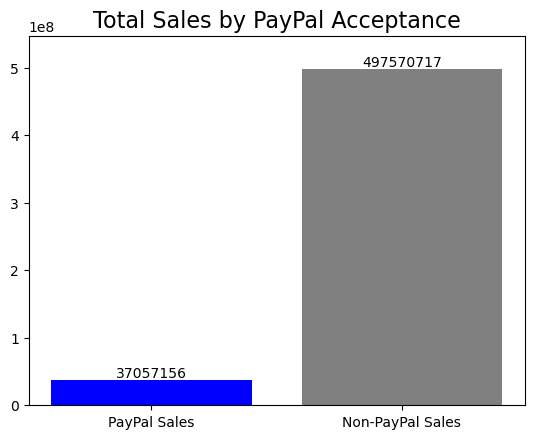

In [26]:
# Data for the bar plot
sales_labels = ['PayPal Sales', 'Non-PayPal Sales']
sales_values = [paypal_sales.sum(), non_paypal_sales.sum()]

# Create the bar plot with custom colors
colors = ['blue', 'grey']
plt.bar(sales_labels, sales_values, color=colors)

# Add labels to the bars
for i, v in enumerate(sales_values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.title('Total Sales by PayPal Acceptance', fontsize=16)
plt.rcParams['font.size'] = 12
plt.ylim(0, max(sales_values) * 1.1)
plt.show()

#### Boxplot of sales distribution – PayPal vs No-PayPal

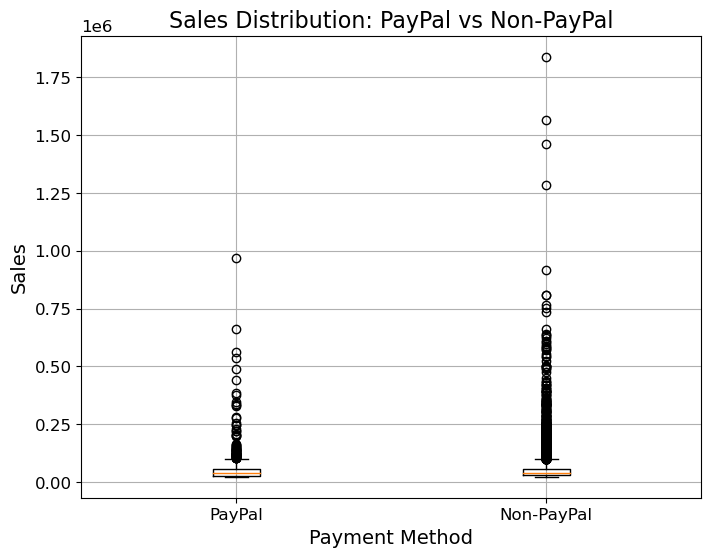

In [27]:
data = [paypal_sales, non_paypal_sales]
labels = ['PayPal', 'Non-PayPal']

# Create a smaller figure with adjusted width
plt.figure(figsize=(8, 6))  # Adjust the width (8 inches) as per your preference

# Create the boxplot
plt.boxplot(data, labels=labels)

# Set the font size for the labels
plt.xticks(fontsize=12)  # Increase the font size for the x-axis labels
plt.yticks(fontsize=12)  # Increase the font size for the y-axis labels

# Set the axis labels and title
plt.xlabel('Payment Method', fontsize=14)  # Increase the font size for the x-axis label
plt.ylabel('Sales', fontsize=14)  # Increase the font size for the y-axis label
plt.title('Sales Distribution: PayPal vs Non-PayPal', fontsize=16)  # Increase the font size for the title

plt.grid(True)
plt.show()

#### Total sales of shops accepting Direct Checkout vs shops not accepting Direct Checkout

In [28]:
direct_checkout_sales = df.loc[df['accepts_direct_checkout'] == True, 'sold_count']
non_direct_checkout_sales = df.loc[df['accepts_direct_checkout'] == False, 'sold_count']

# Direct Checkout Sales
direct_checkout_average_sales = direct_checkout_sales.mean()
direct_checkout_median_sales = direct_checkout_sales.median()
direct_checkout_sales_quartiles = direct_checkout_sales.quantile([0.25, 0.5, 0.75])

# Non-Direct Checkout Sales
non_direct_checkout_average_sales = non_direct_checkout_sales.mean()
non_direct_checkout_median_sales = non_direct_checkout_sales.median()
non_direct_checkout_sales_quartiles = non_direct_checkout_sales.quantile([0.25, 0.5, 0.75])

direct_checkout_total_sales = direct_checkout_sales.sum()
non_direct_checkout_total_sales = non_direct_checkout_sales.sum()

print(f'Total sales in shops accepting Direct Checkout amounted to {direct_checkout_total_sales}')
print(f'Total sales in shops not accepting Direct Checkout amounted to {non_direct_checkout_total_sales}')

Total sales in shops accepting Direct Checkout amounted to 503156466
Total sales in shops not accepting Direct Checkout amounted to 31471407


#### Barplot of total of sales by Direct Checkout Acceptance

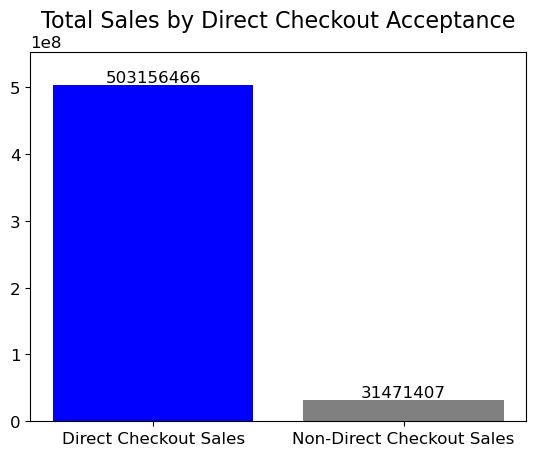

In [29]:
# Data for the bar plot
sales_labels = ['Direct Checkout Sales', 'Non-Direct Checkout Sales']
sales_values = [direct_checkout_total_sales, non_direct_checkout_total_sales]

# Create the bar plot with custom colors
colors = ['blue', 'grey']
plt.bar(sales_labels, sales_values, color=colors)

# Add labels to the bars
for i, v in enumerate(sales_values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Add a title
plt.title('Total Sales by Direct Checkout Acceptance', fontsize=16)
plt.rcParams['font.size'] = 12
plt.ylim(0, max(sales_values) * 1.1)
plt.show()



#### Boxplot of sales distribution – Direct Checkout vs Non-Direct Checkout

Sales Distribution - Direct Checkout:
Average Sales: 53385.30143236074
Median Sales: 36822.0
Sales Quartiles:
0.25    28095.0
0.50    36822.0
0.75    56506.0
Name: sold_count, dtype: float64

Sales Distribution - Non-Direct Checkout:
Average Sales: 55407.406690140844
Median Sales: 35866.0
Sales Quartiles:
0.25    27783.25
0.50    35866.00
0.75    54788.75
Name: sold_count, dtype: float64


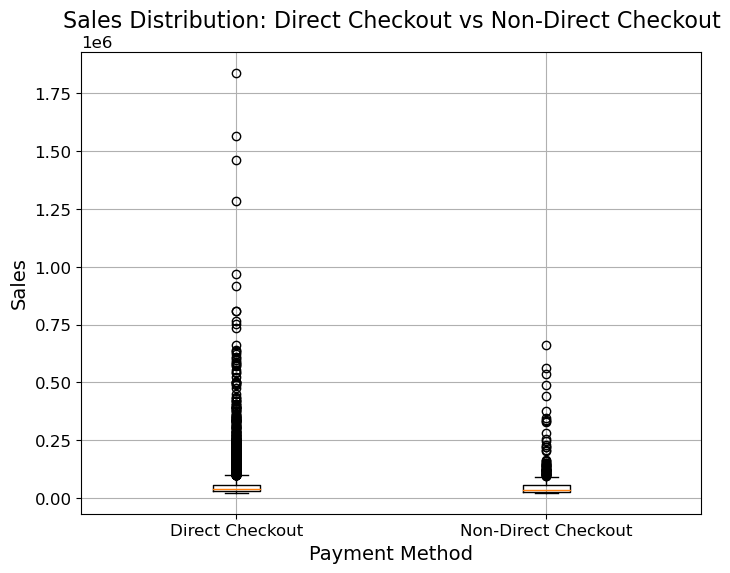

In [30]:
print("Sales Distribution - Direct Checkout:")
print("Average Sales:", direct_checkout_average_sales)
print("Median Sales:", direct_checkout_median_sales)
print("Sales Quartiles:")
print(direct_checkout_sales_quartiles)

print("\nSales Distribution - Non-Direct Checkout:")
print("Average Sales:", non_direct_checkout_average_sales)
print("Median Sales:", non_direct_checkout_median_sales)
print("Sales Quartiles:")
print(non_direct_checkout_sales_quartiles)

data = [direct_checkout_sales, non_direct_checkout_sales]
labels = ['Direct Checkout', 'Non-Direct Checkout']

# Create a smaller figure with adjusted width
plt.figure(figsize=(8, 6))   

# Create the boxplot
plt.boxplot(data, labels=labels)

# Set the font size for the labels
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)   

# Set the axis labels and title
plt.xlabel('Payment Method', fontsize=14)   
plt.ylabel('Sales', fontsize=14)  
plt.title('Sales Distribution: Direct Checkout vs Non-Direct Checkout', fontsize=16) 

plt.grid(True)
plt.show()

#### T-test
Here, since `accepts_direct_checkout` and `accepts_paypal` are binary variables, we can use a t-test to compare the means of `sold_count` for the two groups (accepts vs doesn't accept).

In [31]:
direct_checkout_yes = df[df['accepts_direct_checkout'] == True]['sold_count']
direct_checkout_no = df[df['accepts_direct_checkout'] == False]['sold_count']
t_statistic, p_value = ttest_ind(direct_checkout_yes, direct_checkout_no, equal_var=False)
print(f"T-test statistic for 'sold_count' between shops that accept and don't accept direct checkout: {t_statistic}")
print(f"P-value: {p_value}")

paypal_yes = df[df['accepts_paypal'] == True]['sold_count']
paypal_no = df[df['accepts_paypal'] == False]['sold_count']
t_statistic, p_value = ttest_ind(paypal_yes, paypal_no, equal_var=False)
print(f"T-test statistic for 'sold_count' between shops that accept and don't accept Paypal: {t_statistic}")
print(f"P-value: {p_value}")

T-test statistic for 'sold_count' between shops that accept and don't accept direct checkout: -0.731697386746325
P-value: 0.4646241555662741
T-test statistic for 'sold_count' between shops that accept and don't accept Paypal: 1.790452242229609
P-value: 0.07381825605549605


For the t-tests, there is not a large enough absolute t-statistic and p-value > 0.05, which suggests that the difference in `sold_count` between the groups is *not* statistically significant and is it could be due to chance.

#### Mann-Whitney U test

In [32]:
# Perform Mann-Whitney U test
u_statistic, p_value_mw = stats.mannwhitneyu(paypal_yes, paypal_no)

print("\nMann-Whitney U Test Results:")
print("U-Statistic:", u_statistic)
print("P-Value:", p_value_mw)


Mann-Whitney U Test Results:
U-Statistic: 3000641.5
P-Value: 0.5865647163679146


In [34]:
# Perform Mann-Whitney U test
u_statistic, p_value_mw = stats.mannwhitneyu(direct_checkout_yes, direct_checkout_no)

print("\nMann-Whitney U Test Results:")
print("U-Statistic:", u_statistic)
print("P-Value:", p_value_mw)


Mann-Whitney U Test Results:
U-Statistic: 2721435.5
P-Value: 0.5028786943338861


# RQ4: How does **Active Listing Count**, **Digital Listing Count** and **Shop Age** correlate with the **Sold Count** of a shop?

These three variables have been identified as interesting predictors due to their potential influence on the sales performance of a shop. To better understand their significance, let's visualize their distributions, which will provide insights into why they have been selected for investigation as important predictors.

#### Distribution of Active Listing Count

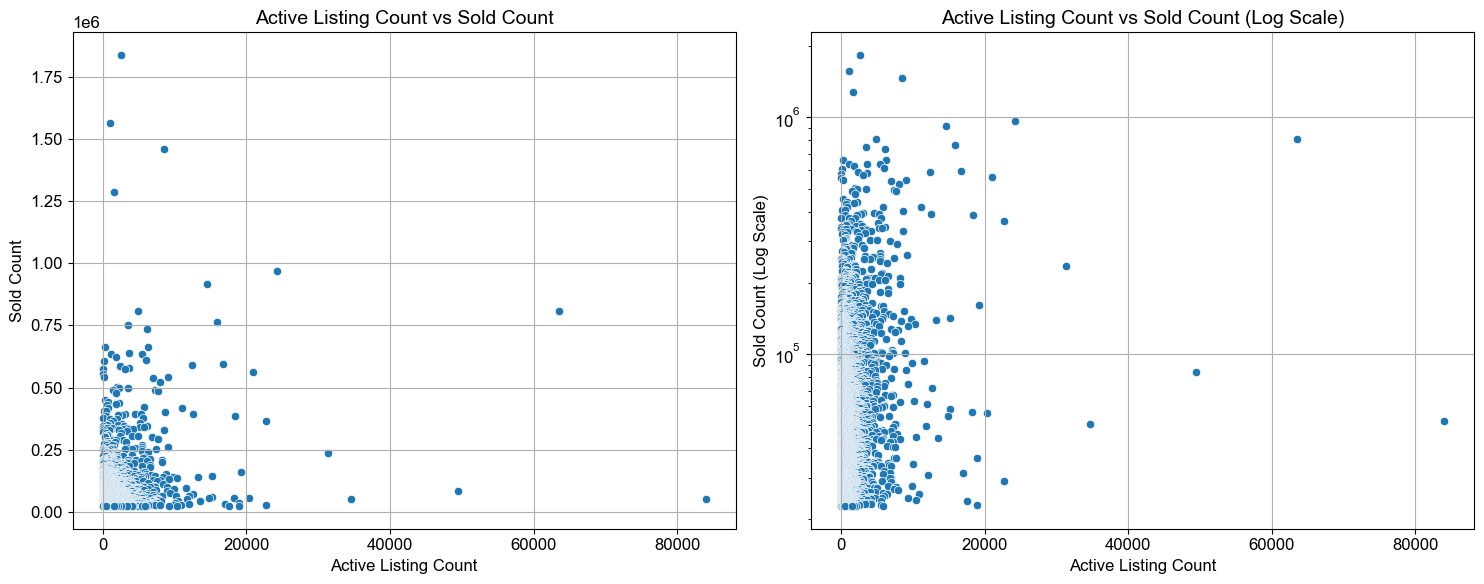

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Update the style to a grid format and set a background style for better viewing
sns.set_style("whitegrid")

# Extract the first subplot: Active Listing Count vs Sold Count
sns.scatterplot(data=df, x='active_listing_count', y='sold_count', ax=axes[0])
axes[0].set_title('Active Listing Count vs Sold Count', fontsize=14)
axes[0].set_xlabel('Active Listing Count', fontsize=12)
axes[0].set_ylabel('Sold Count', fontsize=12)
axes[0].grid(True)

# Create the second subplot: Active Listing Count vs Sold Count in log scale
sns.scatterplot(data=df, x='active_listing_count', y='sold_count', ax=axes[1])
axes[1].set_title('Active Listing Count vs Sold Count (Log Scale)', fontsize=14)
axes[1].set_xlabel('Active Listing Count', fontsize=12)
axes[1].set_ylabel('Sold Count (Log Scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show()

The scatterplot shows the distribution of shops across different Average Rating and Sold Count values. It suggests a positive relationship between the two variables, as higher Average Ratings tend to be associated with higher Sold Counts.

The data points are scattered across the plot, indicating some variability in the relationship between Average Rating and Sold Count. However, a general trend can be observed, where higher Average Ratings tend to be linked with higher Sold Counts. The scatterplot helps visualize this relationship and provides an initial understanding of how the Average Rating may impact the sales performance of Etsy shops.

#### Distribution of **Digital Listing Count** vs **Sold Count**

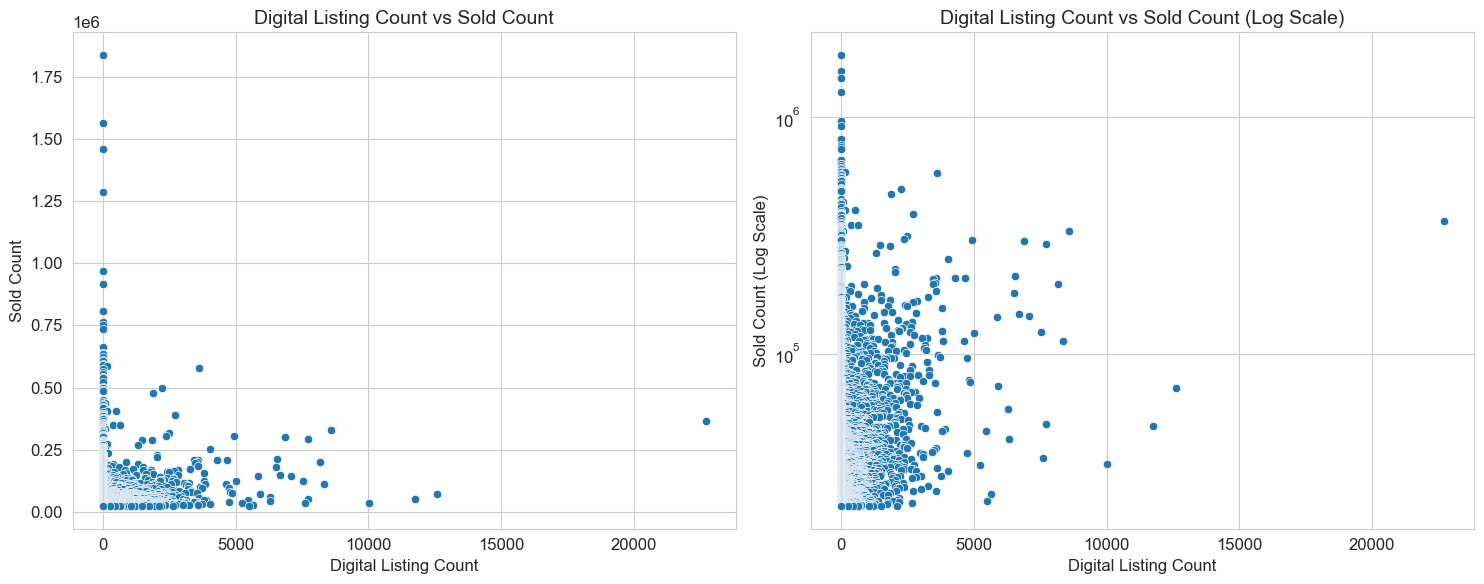

In [36]:
# Set the figure size and create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Update the style to a grid format and set a background style for better viewing
sns.set_style("whitegrid")

# Extract the first subplot: Digital Listing Count vs Sold Count
sns.scatterplot(data=df, x='digital_listing_count', y='sold_count', ax=axes[0])
axes[0].set_title('Digital Listing Count vs Sold Count', fontsize=14)
axes[0].set_xlabel('Digital Listing Count', fontsize=12)
axes[0].set_ylabel('Sold Count', fontsize=12)
axes[0].grid(True)

# Create the second subplot: Digital Listing Count vs Sold Count in log scale
sns.scatterplot(data=df, x='digital_listing_count', y='sold_count', ax=axes[1])
axes[1].set_title('Digital Listing Count vs Sold Count (Log Scale)', fontsize=14)
axes[1].set_xlabel('Digital Listing Count', fontsize=12)
axes[1].set_ylabel('Sold Count (Log Scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show()

<br>
From the scatterplot, we can observe that there is a positive relationship between the Digital Listing Count and the Sold Count. As the Digital Listing Count increases, there tends to be a corresponding increase in the Sold Count. However, the relationship is not strictly linear, and there is some scatter in the data points, indicating some variability in the relationship.

#### The proportion of shops that offer Digital Listings

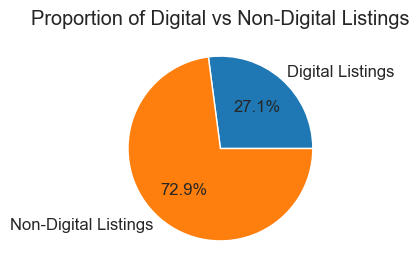

In [37]:
# Calculate the number of shops offering digital listings
digital_listing_shops = np.sum(df['digital_listing_count'] > 0)
non_digital_listing_shops = df.shape[0] - digital_listing_shops

# Plot the pie chart
plt.figure(figsize=(3,3))
plt.pie([digital_listing_shops, non_digital_listing_shops], labels=['Digital Listings', 'Non-Digital Listings'], autopct='%1.1f%%')
plt.title('Proportion of Digital vs Non-Digital Listings')
plt.show()

Almost one third of listings are digital listings

#### The proportion of sales from Digital Listings

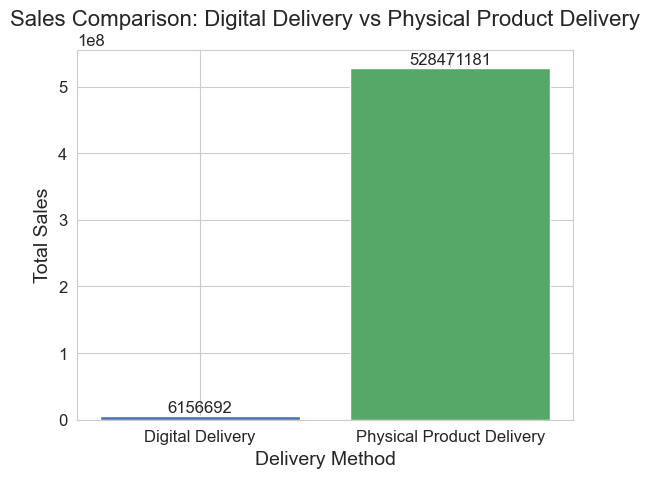

Difference in Sales: -522314489


In [39]:
digital_sales = df.loc[df['digital_delivery_listing_count'] > 0, 'sold_count'].sum()
non_digital_sales = df.loc[df['digital_delivery_listing_count'] == 0, 'sold_count'].sum()

difference = digital_sales - non_digital_sales

colors = ['#4C72B0', '#55A868']
plt.bar(['Digital Delivery', 'Physical Product Delivery'], [digital_sales, non_digital_sales], color=colors)
plt.xlabel('Delivery Method', fontsize=14)  
plt.ylabel('Total Sales', fontsize=14)  
plt.title('Sales Comparison: Digital Delivery vs Physical Product Delivery', fontsize=16)  

for i, v in enumerate([digital_sales, non_digital_sales]):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)   

plt.show()

print("Difference in Sales:", difference)

Although almost 1/3 of listings are digital offerings, there are substantially less digital products being sold compared to physical products. In fact, almost there are x86 physical product sales per every x1 digital sale (528471181/6156692=85.8). Therefore, it would be interesting to explore the exact correlation between digital listings and sold count.

#### Distribution of **Shop Age** vs **Sold Count**

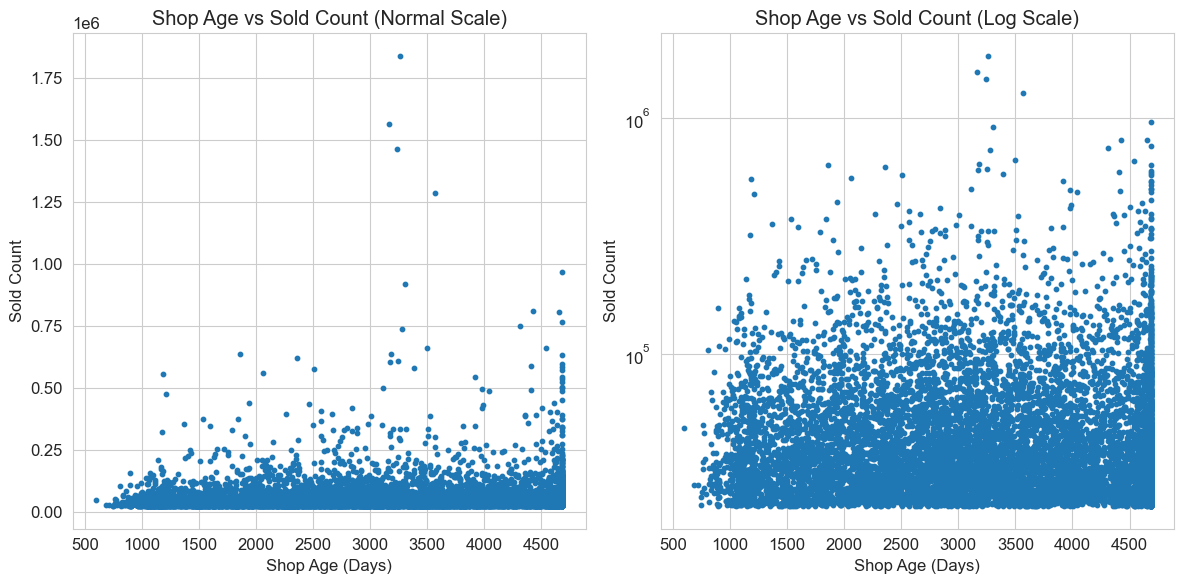

In [40]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Normal scale
ax1.scatter(df['shop_age'], df['sold_count'], s=10) 
ax1.set_title('Shop Age vs Sold Count (Normal Scale)')
ax1.set_xlabel('Shop Age (Days)')
ax1.set_ylabel('Sold Count')

# Subplot 2: Log scale
ax2.scatter(df['shop_age'], df['sold_count'], s=10)   
ax2.set_title('Shop Age vs Sold Count (Log Scale)')
ax2.set_xlabel('Shop Age (Days)')
ax2.set_ylabel('Sold Count')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

The scatter plot shows a generally upward trend, where the data points are more densely packed towards the lower shop age values and spread out towards the higher shop age values. This suggests that older shops tend to have higher sold counts.

However, it is important to note that the relationship between shop age and sold count is not strictly linear. The scatter plot exhibits some variability, indicating that other factors may also influence the sold count. Therefore, while there appears to be a positive correlation between shop age and sold count, it may not be the sole determinant of sales performance.

#### Barplot of **Average Sold Count** by **Shop Age**

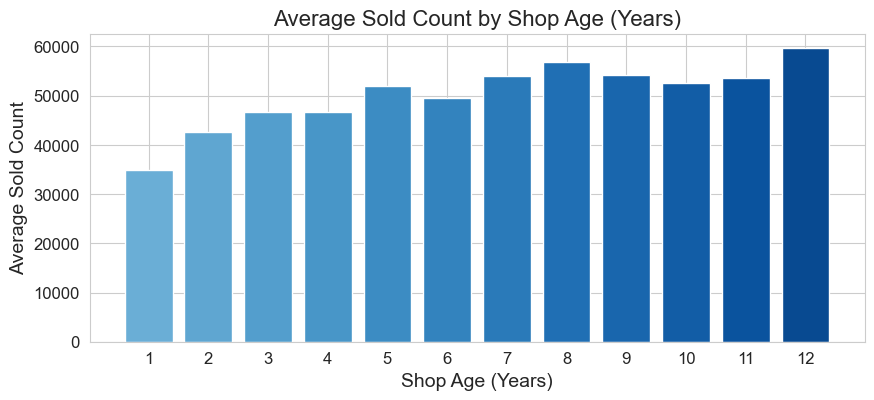

In [41]:
df['shop_age_years'] = np.floor(df['shop_age'] / 365)  # Convert to years

avg_sold_count_years = df.groupby('shop_age_years')['sold_count'].mean()

# Generate a color gradient with a more subtle transition
colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(avg_sold_count_years)))

plt.figure(figsize=(10, 4))  # Adjust the figure size as desired
plt.bar(avg_sold_count_years.index, avg_sold_count_years, color=colors)
plt.title('Average Sold Count by Shop Age (Years)', fontsize=16)  
plt.xlabel('Shop Age (Years)', fontsize=14)   
plt.ylabel('Average Sold Count', fontsize=14)   
plt.grid(True)

plt.xticks(range(1, 13), fontsize=12)
plt.show()

Based on the barplot, it appears that there is a positive correlation between shop age and sold count. As the shop age increases, there is a tendency for the sold count to be higher.

#### OLS analysis
Having examined the distribution and observed potential relationships between Active Listing Count, Digital Listing Count, Shop Age, and Sold Count, it appears that all three variables may exhibit some form of correlation with Sold Count. With this preliminary understanding, we can now move forward and conduct an Ordinary Least Squares analysis using Active Listing Count, Digital Listing Count, and Shop Age as predictors.

In the context of our analysis, using OLS analysis with Active Listing Count, Digital Listing Count, and Shop Age as predictors can help us quantify the relationships between these variables and the sold count. It will allow us to estimate the impact of each predictor on the sold count and assess their statistical significance. OLS can provide valuable insights into the strength and direction of these relationships, aiding in decision-making and further analysis.

In [42]:
# Define the independent variables
X = df[['active_listing_count', 'digital_listing_count', 'shop_age']]

# Add a constant to the independent value
X1 = sm.add_constant(X)

# Make the dependent variable
y = df['sold_count']

# Fit the ordinary least-squares (OLS) model 
model = sm.OLS(y, X1)
results = model.fit()

# Print the model summary
print(results.summary())

parameters = results.params  # extract model parameters 
# parameters now has the coeffs of the predictor variables & the intercept 

significance_level = 0.05
# now we can check the significance of the model 
# by checking if any of the pvalues associated with the model's coeffs are < 0.05 
all_pvalues = results.pvalues
if any(p< significance_level for p in all_pvalues): 
    conclusion="Significant"
else:
    conclusion="NOT significant"

print('The parameters of the model are:')
print(parameters)
print('\nThe model is', conclusion)

                            OLS Regression Results                            
Dep. Variable:             sold_count   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     300.1
Date:                Sun, 02 Jul 2023   Prob (F-statistic):          1.53e-186
Time:                        15:46:37   Log-Likelihood:            -1.2405e+05
No. Observations:                9993   AIC:                         2.481e+05
Df Residuals:                    9989   BIC:                         2.481e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.451e+

#### Shop age and sales
H0: There is no correlation between the shop age and the number of items sold (`sold_count`). <br>
H1: Older shops have sold more items (`sold_count`).

In [43]:
kendall_tau, p_value = stats.kendalltau(df['shop_age'], df['sold_count'])
print("Kendall rank correlation coefficient for shop_age and sold_count: ", kendall_tau)
print("P-value for shop_age and sold_count: ", p_value)

Kendall rank correlation coefficient for shop_age and sold_count:  0.04441736821503588
P-value for shop_age and sold_count:  3.0634975984977436e-11


Result: **Older shops have sold more items** with p < 0.01

#### Active listing count and Sales
H0: There is no correlation between the number of active listings (`active_listing_count`) and the number of items sold (`sold_count`). <br>
H1: There is a positive correlation between the number of active listings (`active_listing_count`) and the number of items sold (`sold_count`).

In [44]:
kendall_tau, p_value = stats.kendalltau(df['active_listing_count'], df['sold_count'])
print("Kendall rank correlation coefficient for active_listing_count and sold_count: ", kendall_tau)
print("P-value for active_listing_count and sold_count: ", p_value)

Kendall rank correlation coefficient for active_listing_count and sold_count:  0.15765408333754893
P-value for active_listing_count and sold_count:  2.3275709451346718e-123


Result: There is a **positive correlation between the number of active listings (`active_listing_count`) and the number of items sold (`sold_count`)** with p < 0.01

#### Digital Listing Count and Sales
H0: There is no correlation between the number of `digital_listing_count` and the number of items sold (`sold_count`). <br>
H1: There is a positive correlation between the number of `digital_listing_count` and the number of items sold (`sold_count`).

In [45]:
kendall_tau, p_value = stats.kendalltau(df['digital_listing_count'], df['sold_count'])
print("Kendall rank correlation coefficient for digital_listing_count and sold_count: ", kendall_tau)
print("P-value for digital_listing_count and sold_count: ", p_value)

Kendall rank correlation coefficient for digital_listing_count and sold_count:  0.0023237442645520985
P-value for digital_listing_count and sold_count:  0.7607596341883849


Result: We **fail to reject the null hypothesis (H0)** that there is no correlation between the number of digital listing counts and the number of items sold with p > 0.05

# RQ5 How well can a **Random Forest Regressor** predict a shop's **Sold Count**, given **six categorical** and **seven numerical** features?

Categorical features:
- Additional customization
- Accepts direct checkout
- Accepts paypal
- Has free shipping
- Is eligible for free shipping
- Has min free shipping

Numerical features:
- Active Listing Count
- Digital Listing Count
- Shop Age (in days)
- Favorites Count
- Average Rating
- Total Rating Count
- Average Rating Count

#### Hyperparameter Tuning

In [46]:
# Define the categorical and numerical features
categorical_features = ['additional_customization', 'accepts_direct_checkout', 'accepts_paypal', 
                        'has_free_shipping', 'is_eligible_free_shipping', 'has_min_free_shipping']
numerical_features = ['active_listing_count', 'digital_listing_count', 'shop_age', 
                      'favorites_count', 'average_rating', 'total_rating_count', 'average_rating_count']

# Prepare the data
X = df[numerical_features + categorical_features]
y = df['sold_count']

# Apply one-hot encoding to categorical features and standard scaling to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Combine preprocessing and model in pipeline
model = RandomForestRegressor()
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])

# First, split the data into training set (70%) and temp set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Then, split the temp set into validation set (15% of the original set) and test set (15% of the original set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the hyperparameters for tuning
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, verbose=0)

# Perform grid search on the training and validation set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Evaluate the model on the test set
model = grid_search.best_estimator_
y_pred = model.predict(X_val)

# Calculate the R-squared and MSE
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Best Hyperparameters:  {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Mean Squared Error: 1697290563.7695155
R-squared: 0.7201120086478447


#### Apply optimal hyperparameters to Random Forest Regressor

In [47]:
# Define the categorical and numerical features
categorical_features = ['additional_customization', 'accepts_direct_checkout', 'accepts_paypal', 
                        'has_free_shipping', 'is_eligible_free_shipping', 'has_min_free_shipping']
numerical_features = ['active_listing_count', 'digital_listing_count', 'shop_age', 
                      'favorites_count', 'average_rating', 'total_rating_count', 'average_rating_count']

# Prepare the data
X = df[numerical_features + categorical_features].copy()
y = df['sold_count']

# Handle missing values
X = X.fillna(X.mean())

# Convert infinity values to NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values (resulted from infinity values) with a specified number or calculated statistical value
# Here, I'm filling with zeros as an example
X.fillna(0, inplace=True)

# Convert binary categorical features to integer
for feature in categorical_features:
    X[feature] = X[feature].astype(int)

# Apply standard scaling to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Combine preprocessing and model in pipeline
model = RandomForestRegressor(n_estimators=400, max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Cross validation
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

# Predicting and calculating metrics
y_pred = pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Cross-validation scores:  [0.77394793 0.77740186 0.73372328 0.75484494 0.80465065]
Mean cross-validation score:  0.7689137337599118
Mean Squared Error: 1537929869.755769
R-squared: 0.7489429013653366


#### Feature Selection – Extract feature importance 

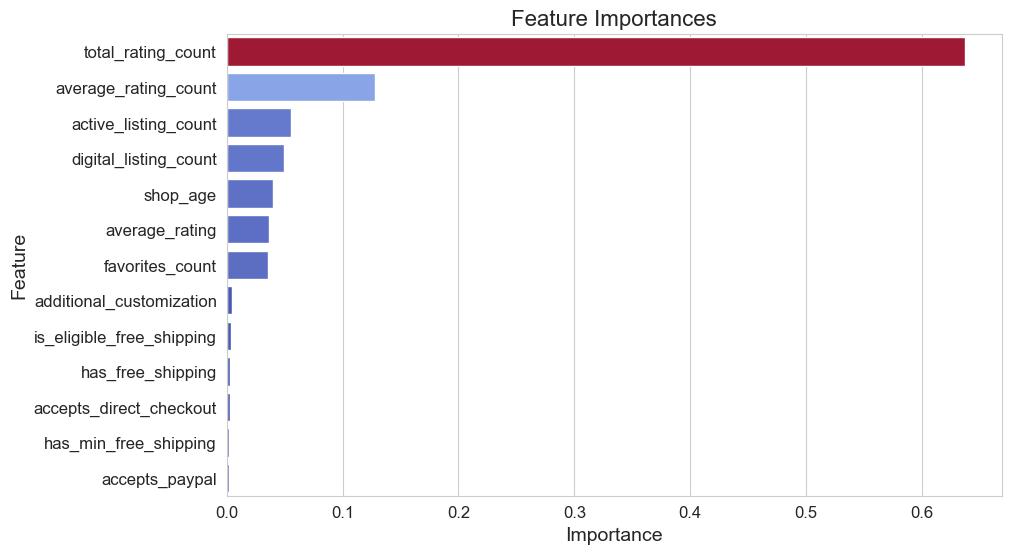

In [48]:
importances = pipe.named_steps['model'].feature_importances_
feature_names = numerical_features + categorical_features

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

norm = Normalize(feature_importances['Importance'].min(), feature_importances['Importance'].max())
colors = plt.cm.coolwarm(norm(feature_importances['Importance']))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colors)
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # Increase tick label size
plt.show()


#### Feature Selection using Correlation Analysis
If our dataset includes irrelevant features, they can make the model more complex and lead to overfitting. By identifying and removing such features, we can potentially improve the model's performance. We will now compute the correlation between all the variables and plots the correlation matrix. 

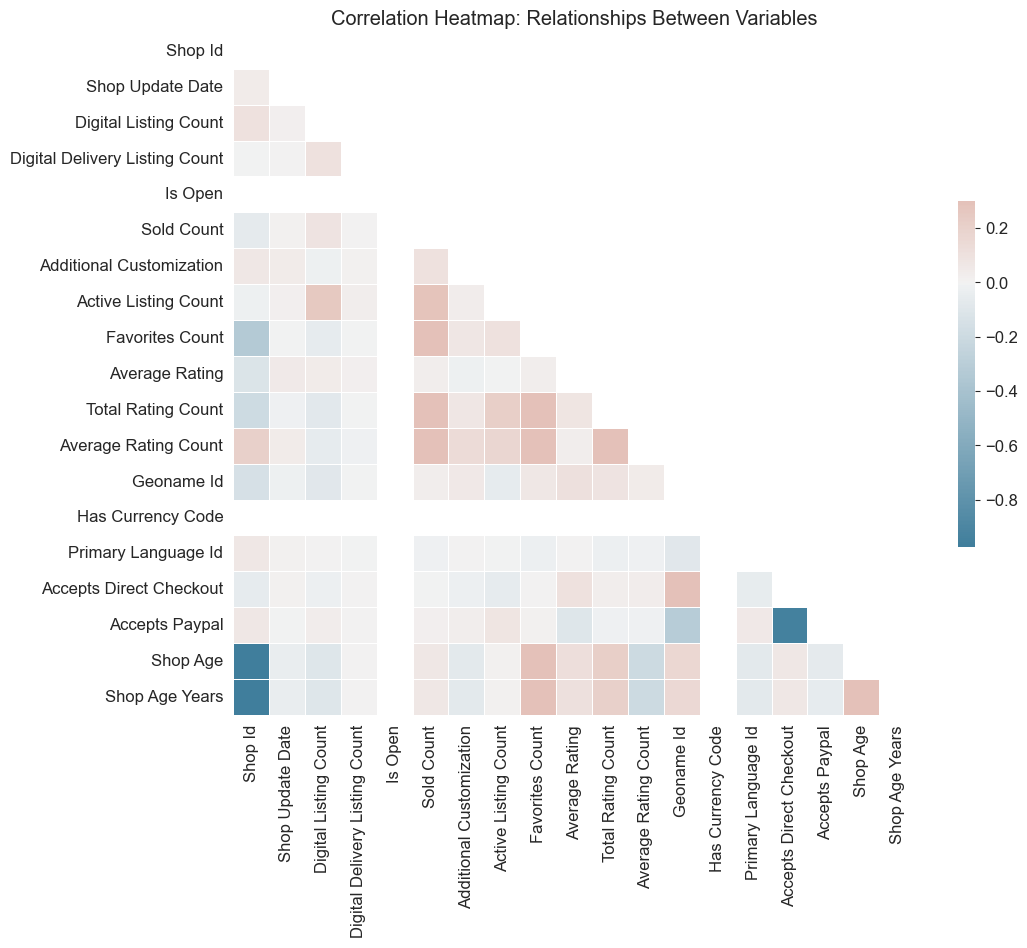

In [49]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Update the column names
corr.columns = [col.replace('_', ' ').title() for col in corr.columns]
corr.index = corr.columns

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap: Relationships Between Variables')  # Add the title
plt.show()

# RQ6 What is the effectiveness of a **Random Forest Regressor** in forecasting a shop's **Sold Count** based on the **top seven features determined by feature importance**?

Numerical features:
1. Total Rating Count
2. Average Rating Count
3. Active Listing Count
4. Digital Listing Count
5. Shop age
6. Average Rating
7. Favorites Count

#### Hyperparameter Tuning

In [50]:
# Prepare the data
X = df[['total_rating_count', 'average_rating_count', 'active_listing_count','digital_listing_count', 'favorites_count', 'shop_age', 'average_rating']]
y = df['sold_count']

# We will use StandardScaler to normalize our feature 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# First, split the data into training set (70%) and temp set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the temp set into validation set (15% of the original set) and test set (15% of the original set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

# Create a RandomForestRegressor
model = RandomForestRegressor()

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)

# Perform grid search on the training and validation set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Evaluate the model  
model = grid_search.best_estimator_
y_pred = model.predict(X_val)

# Calculate the R-squared and MSE
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Mean Squared Error: 1953303339.3595157
R-squared: 0.6959189862344461


#### Apply optimal hyperparameters to Random Forest Regressor

In [51]:
# Merge the training and validation sets
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

# Create a RandomForestRegressor
model = RandomForestRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=400, verbose=0)

# Perform cross validation and compute the mean of the scores
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

# Fit the model to the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the R-squared and MSE
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Cross-validation scores:  [0.78003731 0.7458977  0.80669846 0.79130538 0.67736188]
Mean cross-validation score:  0.7602601457803689
Mean Squared Error: 954471270.184069
R-squared: 0.8360751264038362


# RQ7 How well can a **Gradient Boosting Regressor** predict a shop's **Sold Count**, given **six categorical** and **seven numerical** features?

Categorical features:
- Additional customization
- Accepts direct checkout
- Accepts paypal
- Has free shipping
- Is eligible for free shipping
- Has min free shipping

Numerical features:
- Active Listing Count
- Digital Listing Count
- Shop Age (in days)
- Favorites Count
- Average Rating
- Total Rating Count
- Average Rating Count

#### Hyperparameter Tuning

In [52]:
# Define the categorical and numerical features
categorical_features = ['additional_customization', 'accepts_direct_checkout', 'accepts_paypal', 
                        'has_free_shipping', 'is_eligible_free_shipping', 'has_min_free_shipping']
numerical_features = ['active_listing_count', 'digital_listing_count', 'shop_age', 
                      'favorites_count', 'average_rating', 'total_rating_count', 'average_rating_count']

# Prepare the data
X = df[numerical_features + categorical_features]
y = df['sold_count']

# Apply one-hot encoding to categorical features and standard scaling to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Combine preprocessing and model in pipeline
model = GradientBoostingRegressor()
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])


# First, split the data into training set (70%) and temp set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Then, split the temp set into validation set (15% of the original set) and test set (15% of the original set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

param_grid = {
    'model__n_estimators': [5, 10, 25, 50, 100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.4, 0.6],
    'model__max_depth': [1, 3, 5]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, verbose=-1)

# Perform grid search on the training and validation set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Evaluate the model 
model = grid_search.best_estimator_
y_pred = model.predict(X_val)

# Calculate the R-squared and MSE
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Best Hyperparameters:  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300}
Mean Squared Error: 1095965955.2012162
R-squared: 0.7342802254632786


#### Apply optimal hyperparameters to Gradient Boosting Regressor

In [53]:
# Merge the training and validation sets
X_train = pd.concat([X_train, X_val], ignore_index=True)
y_train = np.concatenate((y_train, y_val))

# Combine preprocessing and model in pipeline
model = GradientBoostingRegressor(n_estimators=300, max_depth=3, learning_rate=0.1, verbose=0)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Cross validation
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

# Predicting and calculating metrics
y_pred = pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Cross-validation scores:  [0.79080368 0.74429813 0.72633521 0.77572757 0.73293533]
Mean cross-validation score:  0.7540199821419554
Mean Squared Error: 1690945885.5670562
R-squared: 0.7211582639418814
